In [25]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder
from torch.optim import Adam

In [26]:
# Root directory for dataset
root_dir = r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of feature maps in generator
ngf = 56

# Number of feature maps in discriminator
ndf = 56

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


In [27]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size, shuffle = True)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([128, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
{'iron': 0}


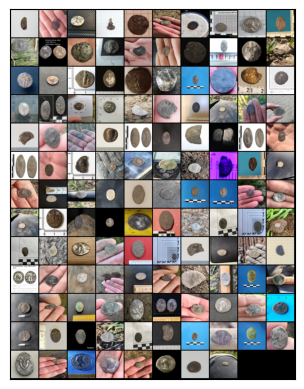

In [28]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [88]:
n_channels = 3 

class D(nn.Module):
    def __init__(
        self,
        hyperparams: dict 
    ): 
        super(D, self).__init__()

        num_layers = hyperparams['num_layers']
        out_channels = hyperparameters['out_channels'][0]  
        kernel_size = hyperparameters['kernel_size'][0]  
        padding = hyperparameters['padding'][0] 
        stride = hyperparameters['stride'][0]
        
        self.layers = nn.ModuleList() 
        final_channel = 0
        final_kernel = 0
        final_padding = 0
        final_stride = 0

        for i in range(num_layers):
            in_channels = n_channels if i == 0 else out_channels[(i - 1) % len(out_channels)]
            out_channel = out_channels[i % len(out_channels)]
            kernel_size_val = kernel_size[i % len(kernel_size)]
            padding_val = padding[i % len(padding)]
            stride_val = stride[i % len(stride)]
            self.layers.append(
                nn.Conv2d(
                    in_channels = in_channels,
                    out_channels = out_channel,
                    kernel_size = kernel_size_val,
                    padding = padding_val,
                    stride = stride_val,
                    bias = False
                )
            )
            self.layers.append(
                nn.BatchNorm2d(
                    out_channels
                )
            )
            self.layers.append(
                nn.LeakyReLU()
            )
            final_channel = out_channel
            final_kernel = kernel_size_val
            final_stride = stride_val
            final_padding = padding_val

        # Last layer 
        self.layers.append(
            nn.Conv2d(
                in_channels = final_channel,
                out_channels = 1, # Final feature map
                kernel_size = final_kernel,
                padding = final_padding,
                stride = final_stride,
                bias = False
            )
        )
        self.layers.append(
            nn.Sigmoid()
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



class G(nn.Module):
    def __init__(
        self,
        hyperparams: dict 
    ): 
        super(G, self).__init__()

        num_layers = hyperparams['num_layers']
        out_channels = hyperparameters['out_channels'][0]  
        kernel_size = hyperparameters['kernel_size'][0]  
        padding = hyperparameters['padding'][0] 
        stride = hyperparameters['stride'][0]
        self.layers = nn.ModuleList() 
        
        final_channel = 0
        final_kernel = 0
        final_padding = 0
        final_stride = 0

        for i in range(num_layers):
            in_channels = n_channels if i == 0 else out_channels[(i - 1) % len(out_channels)]
            out_channel = out_channels[i % len(out_channels)]
            kernel_size_val = kernel_size[i % len(kernel_size)]
            padding_val = padding[i % len(padding)]
            stride_val = stride[i % len(stride)]
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels = in_channels,
                    out_channels = out_channel,
                    kernel_size = kernel_size_val,
                    padding = padding_val,
                    stride = stride_val,
                    bias = False
                )
            )
            self.layers.append(
                nn.BatchNorm2d(
                    out_channels
                )
            )
            self.layers.append(
                nn.ReLU()
            )
            final_channel = out_channel
            final_kernel = kernel_size_val
            final_stride = stride_val
            final_padding = padding_val

        self.layers.append(
            nn.ConvTranspose2d(
                in_channels = final_channel,
                out_channels = 1, # Final feature map
                kernel_size = final_kernel,
                padding = final_padding,
                stride = final_stride,
                bias = False
            )
        )
        self.layers.append(
            nn.Tanh()
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [89]:
def evaluate_performance(d_model, g_model):
    return 1. 

In [91]:
hyperparameters = {
    'learning_rate': [0.1], 
    'batch_size': [32, 64, 128],
    'num_epochs': [30, 40, 50],
    'num_layers': [3, 4, 5],
    'out_channels': [[32, 16, 12]],
    'kernel_size': [[3, 3, 2]],
    'padding': [[0, 1, 0]],
    'stride': [[3, 2, 1], [1, 1, 1]]
}

trials = 10
num_epochs = 50

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

best_score = float('-inf')
best_hyperparams = None

for _ in range(trials):
    # Randomly choose hyperparameters for training 
    sampled_hyperparams = {param: random.choice(values) for param, values in hyperparameters.items()}

    print("SAMPLES: ", sampled_hyperparams)

    d_model = D(sampled_hyperparams) 
    g_model = G(sampled_hyperparams)

    """
    print(d_model)
    print(g_model)
    """

    optimizer = Adam(list(d_model.parameters()) + list(g_model.parameters()), lr = sampled_hyperparams['learning_rate'])
    criterion = nn.BCEWithLogitsLoss() 

    for epoch in range(num_epochs): # Random? 
        for i, data in enumerate(data_loader, 0): 
            print("HELLO") # TODO: FINISH!

    # Min/Max Check
    score = evaluate_performance(d_model, g_model) # TODO: FINISH!

    # Update best score model
    if score > best_score:
        best_score = score
        best_hyperparams = sampled_hyperparams

print("Best hyperparameters:", best_hyperparams)


# TODO: STOP THE TRAINING WHEN THE RESULTS WONT GET BETTER - EXIT CRITERIA

Device:  cuda:0
SAMPLES:  {'learning_rate': 0.1, 'batch_size': 128, 'num_epochs': 50, 'num_layers': 3, 'out_channels': [32, 16, 12], 'kernel_size': [3, 3, 2], 'padding': [0, 1, 0], 'stride': [1, 1, 1]}
HELLO
HELLO
HELLO
HELLO
HELLO
HELLO


KeyboardInterrupt: 